In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid


import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions ((# of images, Height, Width, Color Channel))

transform = transforms.ToTensor()

In [3]:
# Train  Data

train_Data = datasets.MNIST(root=r'MNIST', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:16<00:00, 594kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 66.1kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 526kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 363kB/s]


In [4]:
# Test  Data

test_Data = datasets.MNIST(root=r'MNIST', train=False, download=True, transform=transform)

In [5]:
train_Data

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_Data

Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Create a small batch size for images.... let's say 10
# With this method will load load the images in the set of 10 

train_loader = DataLoader(train_Data, batch_size=10, shuffle=False)
test_loader = DataLoader(test_Data, batch_size=10, shuffle=False)

In [8]:
# Define our CNN model
# Describe convolution layer and what it's doing ( 2 convolution layer)

conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)


In [9]:
# Grab 1 Mnist record/image
for i, (X_Train, y_train) in enumerate(train_Data):
    break

In [10]:
X_Train.shape

torch.Size([1, 28, 28])

In [11]:
x = X_Train.view(1, 1, 28, 28)

In [12]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [13]:
# 1 single image, 6 is the filters we asked for, 26x26 because of padding
x.shape


torch.Size([1, 6, 26, 26])

In [14]:
# pass thru the pooling layer
x = F.max_pool2d(x, 2, 2) #kernal of 2 and stride of 2

In [15]:
x.shape #26 / 2 13

torch.Size([1, 6, 13, 13])

In [16]:
# Do our second convolution layer
x = F.relu(conv2(x)) 

In [17]:
x.shape # Again, We did not set padding so we lose 2 pixles around the images

torch.Size([1, 16, 11, 11])

In [18]:
#Pooling layer
x = F.max_pool2d(x, 2, 2) #kernal of 2 and stride of 2

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
#Model Class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # Fully Connected layer
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2, 2) # 2x2 kernal and strikde 2

        #Second Pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2, 2) # 2x2 kernal and strikde 2

        #Re-view to flatenn i out 
        X = X.view(-1, 16*5*5) # negative one so that we can vary the batch size

        # Fully Connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)


In [21]:
# Create an instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.02) # Smaller the learning, longer it take to get the result

In [23]:
import time
start_time = time.time()

# Create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    test_corr = 0
    batch_corr = 0

    # Training
    model.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())            # .item() to store a float
    train_correct.append(trn_corr.item())       # Convert tensor to int

    # Testing (Moved inside epoch loop)
    model.eval()
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)  # last batch loss
        test_losses.append(loss.item())             # .item()
        test_correct.append(test_corr.item())       # .item()

    # Optional print per epoch
    print(f"Epoch {i+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Timer
current_time = time.time()
print(f"Training took: {current_time/60:.2f} minutes")


Epoch 1/5, Train Loss: 0.0046, Test Loss: 0.0839
Epoch 2/5, Train Loss: 0.0177, Test Loss: 0.4629
Epoch 3/5, Train Loss: 0.0042, Test Loss: 0.4292
Epoch 4/5, Train Loss: 0.3243, Test Loss: 0.0374
Epoch 5/5, Train Loss: 0.0324, Test Loss: 0.2945
Training took: 29209858.39 minutes


import time
start_time = time.time()

# Create variables to Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For loops of epochs
for i in range(epochs):
    trn_corr = 0
    test_corr = 0
    batch_corr = 0

    #Train 
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1 # Start pir batches in 1
        y_pred = model(X_train) #get predicted values form the traininn data set not flattended 2D
        loss = criterion(y_pred, y_train)
        prdicted = torch.max(y_pred, 1)[1] # add up the number of correct predictions. Indexed of first point
        bach_corr = (prdicted == y_train).sum()
        trn_corr += batch_corr # Keep train as we go along in training
        
        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print out some reults
    if b%600 == 0:
        print(f"Epcoh {i} Batch {b},  Loss : {loss.item()}")

    
    train_losses.append(loss)
    test_losses.append(loss)
    train_correct.append(trn_corr)
    test_correct.append(test_corr)
    


#Test 
with torch.no_grad(): #No gradient so we do not update our weights and biases with test
    for b, (X_test, y_test) in enumerate(test_loader):
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1] #Adding up  correct predictions
        test_corr += (predicted == y_test).sum() # T=1 F=0 and sum away

loss = criterion(y_val, y_test)



current_time = time.time()
total = current_time-start_time
print(f"Training took : {total/60} minutes")

In [24]:
print(f"Train losses: {len(train_losses)}, Test losses: {len(test_losses)}")

Train losses: 5, Test losses: 5


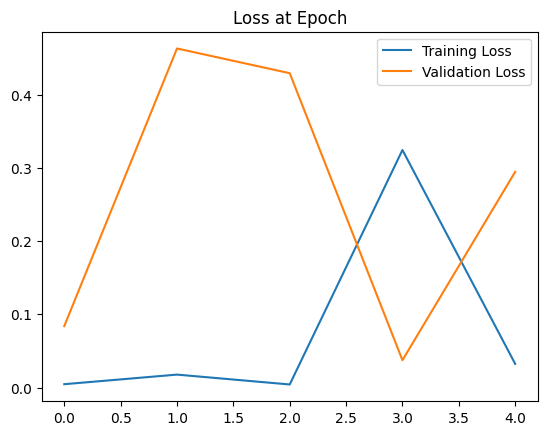

In [25]:
#train_losses = [tl.item() for tl in train_losses]
#test_losses = [tl.item() for tl in test_losses]

# Graph the loss at epoch
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

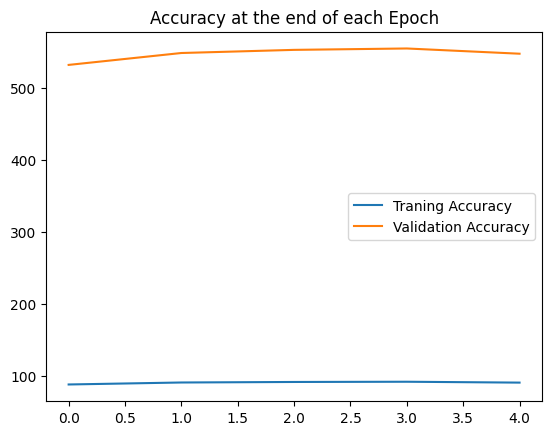

In [26]:
# Graph the accuracy at the end of the each epoch
plt.plot([t/600 for t in train_correct], label="Traning Accuracy")
plt.plot([t/100 for t in train_correct], label ="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [27]:

test_load_everthing = DataLoader(test_Data, batch_size=100, shuffle=False)

In [28]:
with torch.no_grad():
	correct = 0
	for X_test, y_test in test_load_everthing:
		y_val = model(X_test)
		predicted = torch.max(y_val, 1)[1]
		correct += (predicted == y_test).sum()

In [29]:
# Did for correct 
correct.item()


8977

In [30]:
# Grab an image
test_Data[4143] # Tensor with an image in it.. at end shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [31]:

# Grab just the data
test_Data[4143][0] # Tensor without lable

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [32]:
#Reshape it
test_Data[4143][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

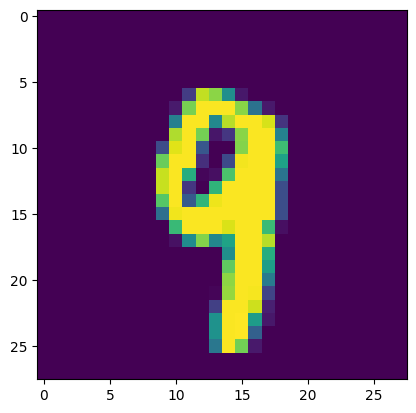

In [33]:
# Show the image
plt.imshow(test_Data[4143][0].reshape(28, 28))

In [34]:

#pass teh image thru our model
model.eval()
with torch.no_grad():
	new_prediction = model(test_Data[4143][0].view(1,1, 28, 28)) # batch size of 1, 1, color channel, 28 x 28 image


In [35]:
# Check the new prdiction.. get probablilites
new_prediction 

tensor([[-1.3770e+01, -1.8748e+01, -2.6180e+01, -1.3035e+01, -1.1676e+01,
         -1.8328e+01, -6.6133e+01, -6.9311e+00, -1.2687e+01, -9.9216e-04]])

In [36]:
new_prediction.argmax()

tensor(9)